In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Input
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [0]:

!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 6.2MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:

fileId = drive.CreateFile({'id': '1kcxLKBFSX3JTg38gxqza_MUpyhROP803'}) #DRIVE_FILE_ID https://drive.google.com/open?id=1kcxLKBFSX3JTg38gxqza_MUpyhROP803
print (fileId['title'])  # folder_data.zip
fileId.GetContentFile('data.zip')  

data.zip


In [0]:
!unzip data.zip -d ./

Archive:  data.zip
   creating: ./data/
   creating: ./data/train/
   creating: ./data/train/not_pool/
 extracting: ./data/train/not_pool/1.png  
 extracting: ./data/train/not_pool/10.png  
 extracting: ./data/train/not_pool/100.png  
 extracting: ./data/train/not_pool/102.png  
 extracting: ./data/train/not_pool/103.png  
 extracting: ./data/train/not_pool/105.png  
 extracting: ./data/train/not_pool/106.png  
 extracting: ./data/train/not_pool/107.png  
 extracting: ./data/train/not_pool/108.png  
 extracting: ./data/train/not_pool/109.png  
 extracting: ./data/train/not_pool/11.png  
 extracting: ./data/train/not_pool/110.png  
 extracting: ./data/train/not_pool/111.png  
 extracting: ./data/train/not_pool/112.png  
 extracting: ./data/train/not_pool/113.png  
 extracting: ./data/train/not_pool/114.png  
 extracting: ./data/train/not_pool/115.png  
 extracting: ./data/train/not_pool/116.png  
 extracting: ./data/train/not_pool/117.png  
 extracting: ./data/train/not_pool/118.png  
 

In [0]:
img_width, img_height = 128, 128
train_data_dir = "data/train"
validation_data_dir = "data/val"
nb_train_samples = 1500
nb_validation_samples = 250
batch_size = 5
epochs = 25

In [0]:
input_dim = (img_width, img_height, 3)
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:17]:
    layer.trainable = False

In [0]:
#Adding custom Layers 
# x = model.output
# x = Flatten()(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
# predictions = Dense(1, activation="softmax")(x)

# model = Sequential()
# model.add(Flatten(input_shape=model.output))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

input_tensor = Input(shape=input_dim)
bn = BatchNormalization()(input_tensor)
x = model(bn)
x = Flatten()(x)
# x = Dense(256, activation="relu")(x)
# x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)
# output = Dense(1, activation='sigmoid')(x)




# add_model = Sequential()
# add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# add_model.add(Dense(256, activation='relu'))
# add_model.add()


In [0]:
# creating the final model 
# model_final = Model(input = model.input, output = predictions)
model_final = Model(input_tensor, output)
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_24 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 16386     
Total params: 20,040,782
Trainable params: 9,455,624
Non-trainable params: 10,585,158
_________________________________________________________________


In [0]:
from keras.optimizers import Adam
# compile the model 
model_final.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
# model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])

# model.compile(loss='binary_crossentropy',  optimizer='rmsprop', metrics=['accuracy'])

In [0]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
shear_range=0.2)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 1508 images belonging to 2 classes.
Found 175 images belonging to 2 classes.


In [0]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("pool.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss',  min_delta=1e-4, patience=3, verbose=1, mode='auto')
reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1)

In [0]:
# Train the model 
history = History()
model_final.fit_generator(
train_generator,
samples_per_epoch = nb_train_samples,
epochs = epochs,
validation_data = validation_generator,
nb_val_samples = nb_validation_samples,
callbacks = [history,checkpoint, early,reduceLr])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=25, validation_data=<keras.pre..., callbacks=[<keras.ca..., steps_per_epoch=300, validation_steps=250)`
  


Epoch 1/25
300/300 [==============================] - 184s 615ms/step - loss: 0.6807 - acc: 0.6053 - val_loss: 0.5634 - val_acc: 0.7356

Epoch 00001: val_acc improved from -inf to 0.73559, saving model to pool.h5
Epoch 2/25
300/300 [==============================] - 183s 610ms/step - loss: 0.5639 - acc: 0.7098 - val_loss: 0.5176 - val_acc: 0.7413

Epoch 00002: val_acc improved from 0.73559 to 0.74134, saving model to pool.h5
Epoch 3/25
300/300 [==============================] - 182s 608ms/step - loss: 0.4109 - acc: 0.8216 - val_loss: 0.5793 - val_acc: 0.7074

Epoch 00003: val_acc did not improve from 0.74134

Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 4/25
300/300 [==============================] - 184s 613ms/step - loss: 0.3146 - acc: 0.8793 - val_loss: 0.4772 - val_acc: 0.7706

Epoch 00004: val_acc improved from 0.74134 to 0.77064, saving model to pool.h5
Epoch 5/25
300/300 [==============================] - 184s 614ms/step - loss: 0.2707 - 

In [0]:
model_final.save("pool_4.h5")

In [0]:
def gen_link(file):
  # Install the PyDrive wrapper & import libraries.
  # This only needs to be done once in a notebook.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  
  # Authenticate and create the PyDrive client.
  # This only needs to be done once in a notebook.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  
  # Create & upload a file.
  uploaded = drive.CreateFile({'title': file})
  uploaded.SetContentFile(file)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))
  print('https://drive.google.com/file/d/' + str(uploaded.get('id')) + '/view')

In [0]:
gen_link('pool_1.h5')

Uploaded file with ID 1vEYYmzjFdlyZVPA_FdLHbMXHEc_4HbPm
https://drive.google.com/file/d/1vEYYmzjFdlyZVPA_FdLHbMXHEc_4HbPm/view


In [0]:
# Freezed all layers except the added layers
gen_link('pool_2.h5')

Uploaded file with ID 1dt2XkrHISCkNdrmam5ZEC1tO5cd9QHR7
https://drive.google.com/file/d/1dt2XkrHISCkNdrmam5ZEC1tO5cd9QHR7/view


In [0]:
# With class mode binary and activation sigmoid with one node
gen_link('pool_3.h5')

Uploaded file with ID 12OSV4D7fzO8Qryje72r3mLmYaAb2U4oO
https://drive.google.com/file/d/12OSV4D7fzO8Qryje72r3mLmYaAb2U4oO/view


In [0]:
# Freeze few nodes with softmax as activation
gen_link('pool_4.h5')

Uploaded file with ID 100HWN5ALVslDC7k67IaUHrl2uGJv_HCd
https://drive.google.com/file/d/100HWN5ALVslDC7k67IaUHrl2uGJv_HCd/view


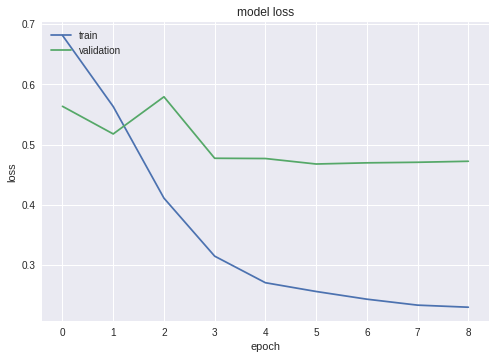

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'pool_4.h5'})
uploaded.SetContentFile('pool_4.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
print('https://drive.google.com/file/d/' + str(uploaded.get('id')) + '/view')

FileNotFoundError: ignored

In [0]:
import urllib.request
def downloadMapImage(lat,lng,img_path):
  url = "http://maps.googleapis.com/maps/api/staticmap?center=" + str(lat) + "," + str(lng) + "&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32"
  print(url)
  urllib.request.urlretrieve(url, img_path)

In [0]:
from matplotlib.pyplot import imshow 
from matplotlib import pyplot as plt
from keras.preprocessing import image
import numpy as np
def check_for_pool(lat,lng):
  """accepts lat and lng of a location and checks if pool is present"""
  # Download the image
  img_path = 'img.png'
  downloadMapImage(lat,lng, img_path)
  # preprocess the image and send for prediction
   
  img = image.load_img(img_path, target_size=(128, 128))
#   imshow(img)
  plt.figure(figsize=(7,7))
  plt.imshow(img)
  plt.grid(True)
  plt.xticks([])
  plt.yticks([])
  img = np.reshape(img,[1,128,128,3])
  return decode_predictions(model_final.predict(img))

In [0]:
from operator import itemgetter
classes = ["No Swimming Pool","Swimming Pool"]
def decode_predictions(pred):
    pred = dict(zip(classes, pred.tolist()[0]))
    return sorted(pred.items(), key=itemgetter(1))

http://maps.googleapis.com/maps/api/staticmap?center=30.171399,-95.484196&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


NameError: ignored

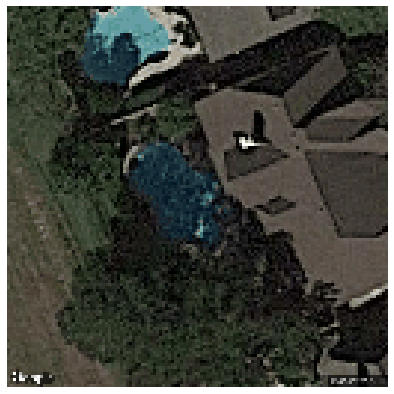

In [0]:
check_for_pool(30.171399,-95.484196)

http://maps.googleapis.com/maps/api/staticmap?center=29.8687848,-95.403973&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('No Swimming Pool', 2.5561733658743916e-29), ('Swimming Pool', 1.0)]

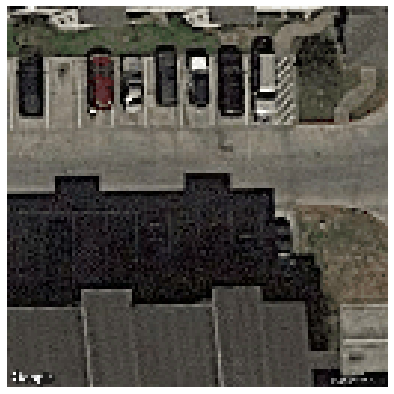

In [0]:
check_for_pool(29.8687848,-95.403973)

http://maps.googleapis.com/maps/api/staticmap?center=29.814885,-95.556619&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('No Swimming Pool', 5.45895891264081e-05),
 ('Swimming Pool', 0.9999454021453857)]

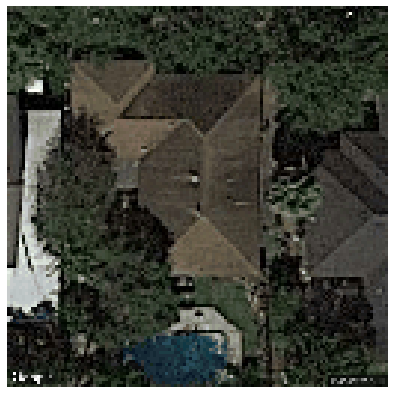

In [0]:
check_for_pool(29.814885,-95.556619)

http://maps.googleapis.com/maps/api/staticmap?center=29.868703,-95.400195&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('Swimming Pool', 0.0), ('No Swimming Pool', 1.0)]

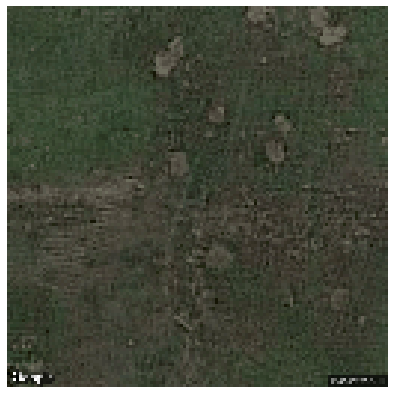

In [0]:
check_for_pool(29.868703,-95.400195)

http://maps.googleapis.com/maps/api/staticmap?center=29.78788,-95.36138&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('Swimming Pool', 0.0), ('No Swimming Pool', 1.0)]

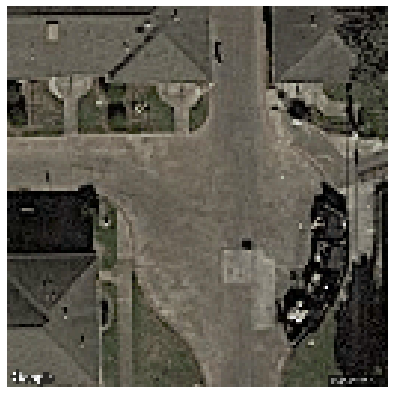

In [0]:
check_for_pool(29.787880,-95.361380)

http://maps.googleapis.com/maps/api/staticmap?center=29.958554,-95.469023&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('No Swimming Pool', 1.544676744805358e-37), ('Swimming Pool', 1.0)]

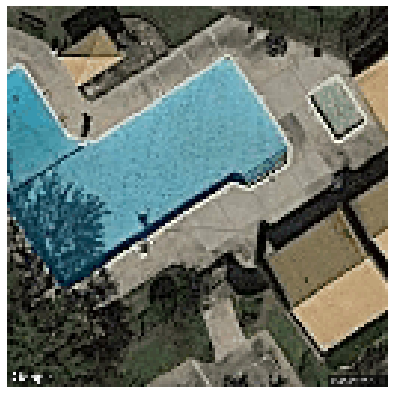

In [0]:
check_for_pool(29.958554,-95.469023)

http://maps.googleapis.com/maps/api/staticmap?center=30.157796,-95.501485&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('Swimming Pool', 0.12668541073799133),
 ('No Swimming Pool', 0.8733145594596863)]

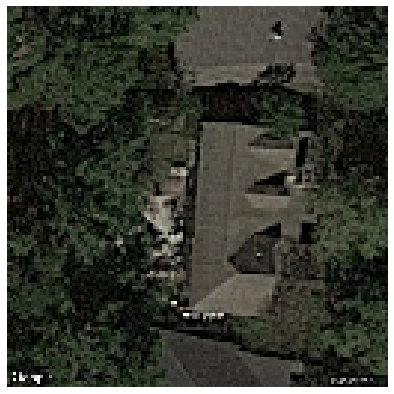

In [0]:
check_for_pool(30.157796,-95.501485)

http://maps.googleapis.com/maps/api/staticmap?center=30.156679,-95.506574&size=500x500&zoom=21&sensor=true&maptype=satellite&scale=1&format=png32


[('No Swimming Pool', 4.382038605886536e-34), ('Swimming Pool', 1.0)]

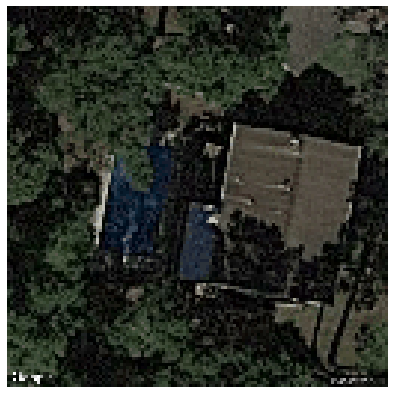

In [0]:
check_for_pool(30.156679,-95.506574)